# Кластеризация предложений

# Настройка колаба

In [ ]:
!nvidia-smi

Sat Feb  6 05:59:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 1.8MB 28.5MB/s 
     |████████████████████████████████| 1.2MB 53.5MB/s 
     |████████████████████████████████| 890kB 44.9MB/s 
     |████████████████████████████████| 2.9MB 54.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp36-none-any.whl size=103068 sha256=4aa4614bce4bcbab5d5b39a16aabdd07fca38ec64e119fc18f26942905288f9a
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=2861cbad61251355f0ced9d8baad46bc3a89a16d10c4f5f201550583ef733735
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Библиотеки

In [ ]:
import json
import os
#from google.colab import drive
from tqdm import tqdm
import pickle
from collections import Counter
import time

import pandas as pd

import numpy as np
import scipy
from scipy import spatial

import torch
from sentence_transformers import SentenceTransformer, util
#from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS

import matplotlib.pyplot as plt
import seaborn as sns

# Функции

выделение кластера

In [ ]:
def community_detection(embeddings, threshold=0.75, min_community_size=25, init_max_size=1000):
    """
    Function for Fast Community Detection
    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).
    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    # Compute cosine similarity scores
    cos_scores = util.pytorch_cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

def make_clusters_print(df, sentences='body', embeddings='embedding'):
    corpus_sentences = list(df[sentences])
    corpus_embeddings = list(df[embeddings])

    print("Start clustering")
    start_time = time.time()

    #Two parameter to tune:
    #min_cluster_size: Only consider cluster that have at least 25 elements (30 similar sentences)
    #threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
    clusters = community_detection(corpus_embeddings)

    print('Кол-во кластеров:', len(clusters))
    for cluster in range(len(clusters)):
        print(f'Кол-во элементов в кластере {cluster}:', len(clusters[cluster]))

    #Print all cluster / communities
    '''
    for i, cluster in enumerate(clusters):
        print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
        for sentence_id in cluster:
            print("\t", corpus_sentences[sentence_id])
    '''

    print("Clustering done after {:.2f} sec".format(time.time() - start_time))
    return clusters

def add_clusters_to_df(clusters,
                       df,
                       ):
    for i, cluster in enumerate(clusters):
        for row in cluster:
            try:
                df.iloc[row, -1] = i
            except:
                pass

отрисовка графика и понижение размерности

In [ ]:
def plot_2d_pca_representation_of_sentence(
    data, 
    embedding="embedding",
    label = "label",
    alpha=0.4
):
    
    pca = PCA(n_components = 2)
    
    sentence_vectors = list(data[embedding])
    sentence_plus_coordinates = pd.DataFrame(sentence_vectors)
    
    labels = data[label].reset_index(drop=True)
    
    coordinates_2d = pca.fit_transform(sentence_plus_coordinates)
    coordinates_2d = pd.DataFrame(coordinates_2d, columns=['x', 'y'])
    coordinates_2d = pd.concat([coordinates_2d, labels], axis=1)
            
    plt.figure(figsize = (15,10))
    p1=sns.scatterplot(data=coordinates_2d, x='x', y='y', hue=label, alpha=alpha)
    
    x = coordinates_2d['x']
    y = coordinates_2d['y']
    
    plt.show()


def plot_2d_tsne_representation_of_sentence(
    data, 
    embedding="embedding",
    label = "label",
    alpha=0.4
):
    
    tsne = TSNE(n_components = 2)
    
    sentence_vectors = list(data[embedding])
    sentence_plus_coordinates = pd.DataFrame(sentence_vectors)
    
    labels = data[label].reset_index(drop=True)
    
    coordinates_2d = tsne.fit_transform(sentence_plus_coordinates)
    coordinates_2d = pd.DataFrame(coordinates_2d, columns=['x', 'y'])
    coordinates_2d = pd.concat([coordinates_2d, labels], axis=1)
            
    plt.figure(figsize = (15,10))
    p1=sns.scatterplot(data=coordinates_2d, x='x', y='y', hue=label, alpha=alpha)
    
    x = coordinates_2d['x']
    y = coordinates_2d['y']
    
    plt.show()

# Предобученная модель

Скачиваем предобученную модель

In [ ]:
#model = SentenceTransformer('bert-base-nli-mean-tokens') #эта быстрее
model = SentenceTransformer('bert-large-nli-mean-tokens') #эта точнее


100%|██████████| 1.24G/1.24G [02:27<00:00, 8.41MB/s]


# Датасет трамп_байден2020 комментс

Проверям папку

In [ ]:
comments_dir = "/content/drive/My Drive/PoliticalDiscussion"
os.listdir(comments_dir)[:5]

['JoeBiden_comments_2020_clean.csv', 'Trump_comments_2020_clean.csv']

In [ ]:
%%time
d = dict()

for my_file in tqdm(os.listdir(comments_dir), position=0, leave=True):
    with open(os.path.join(comments_dir, my_file), encoding="utf8") as csv_file:
        d[my_file] = pd.read_csv(csv_file)

100%|██████████| 2/2 [00:12<00:00,  6.39s/it]

CPU times: user 4.43 s, sys: 591 ms, total: 5.02 s
Wall time: 12.8 s


In [ ]:
# add part column with trump
d['Trump_comments_2020_clean.csv']['part'] = np.nan
d['Trump_comments_2020_clean.csv']['part'] = d['Trump_comments_2020_clean.csv']['part'].fillna('trump')

# add part column with biden
d['JoeBiden_comments_2020_clean.csv']['part'] = np.nan
d['JoeBiden_comments_2020_clean.csv']['part'] = d['JoeBiden_comments_2020_clean.csv']['part'].fillna('biden')

In [ ]:
comments_df = pd.concat([d['Trump_comments_2020_clean.csv'], d['JoeBiden_comments_2020_clean.csv']])
del(d)
comments_df.shape

(1118400, 8)

In [ ]:
comments_df.sample(2)

,Unnamed: 0,author,body,created_utc,link_id,parent_id,score,part
173626,173626,classic_snapping,I don't think that quibbling over the label is...,1596672248,t3_i4fs85,t1_g0i3lrr,1.0,biden
259841,259841,midnightprism,I'm here. I'm voting early in person.,1601448124,t3_j24p4n,t3_j24p4n,1.0,biden


In [ ]:
comments_df = comments_df.drop(['Unnamed: 0'], axis=1)

# Embedding

обрежем длинные комментарии до 512 слов

In [ ]:
comments_df['body'] = comments_df['body'].astype('str')

In [ ]:
def cut_comment(row):
    if len(row.split()) > 300:
        return ' '.join(list(row.split())[0][:512])
    else:
      return row

In [ ]:
comments_df['body'] = comments_df['body'].apply(cut_comment)
comments_df.head(2)

,author,body,created_utc,link_id,parent_id,score,part
0,khalabrakis,"Fighters... That means warrior, like people wh...",1577836803,t3_ei6h2x,t3_ei6h2x,1.0,trump
1,Whopper_Jr,It’s plausible that Republicans will never win...,1577836806,t3_ei4ag7,t3_ei4ag7,1.0,trump


взяли выборку из 40 комментариев

In [ ]:
%%time
comments_df = comments_df.sample(40000)  # пробуем на маленькой выборке
comment_embedding = model.encode(comments_df['body'].to_list(), show_progress_bar=True, convert_to_numpy=True, device='cuda')
comments_df['embedding'] = list(comment_embedding)

NameError: ignored

In [ ]:
comments_df['part'].value_counts()

Сохраняем таблицу с вложениями

In [ ]:
#with open('/content/drive/My Drive/weights/comments_df.pickle', 'wb') as f:
#  pickle.dump(comments_df, f)

# Кластеризация fast_clustering

In [ ]:
comments_df["label"] = np.nan
comments_df.head(2)

In [ ]:
%%time
add_clusters_to_df(make_clusters_print(comments_df), comments_df)
comments_df.sample()

Start clustering
Кол-во кластеров: 3
Кол-во элементов в кластере 0: 24023
Кол-во элементов в кластере 1: 1508
Кол-во элементов в кластере 2: 116
Clustering done after 199.58 sec
CPU times: user 3min 37s, sys: 16.7 s, total: 3min 54s
Wall time: 3min 29s


понижение размерности PCA

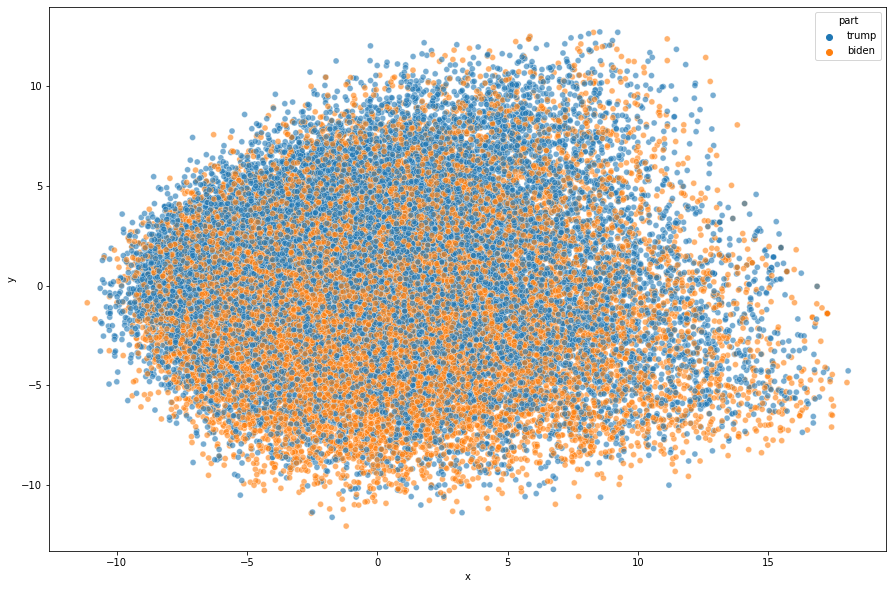

CPU times: user 23.7 s, sys: 5.03 s, total: 28.7 s
Wall time: 20.7 s


In [ ]:
%%time
plot_2d_pca_representation_of_sentence(comments_df, alpha=0.6, label='part')

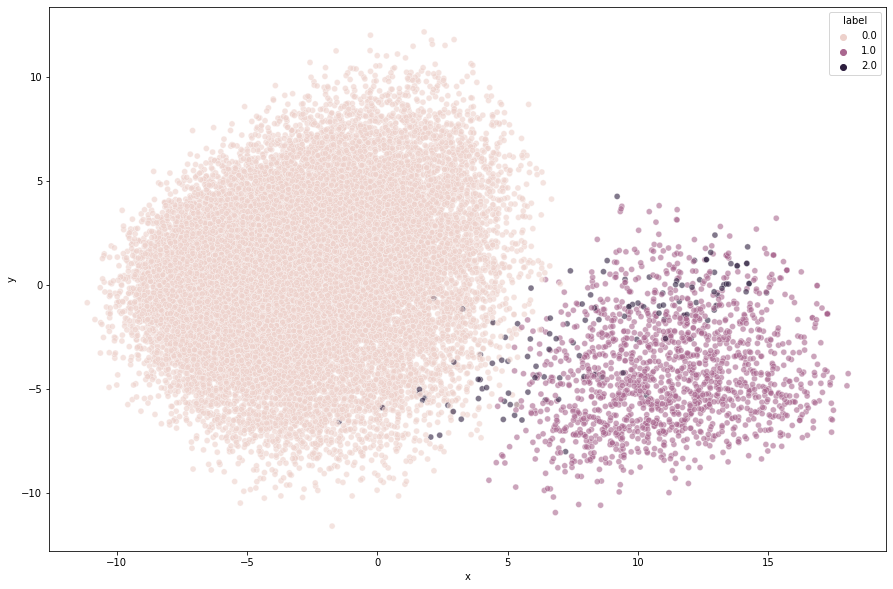

CPU times: user 23.3 s, sys: 4.74 s, total: 28.1 s
Wall time: 19.8 s


In [ ]:
%%time
plot_2d_pca_representation_of_sentence(comments_df, alpha=0.6)

Понижение размерности TSNE



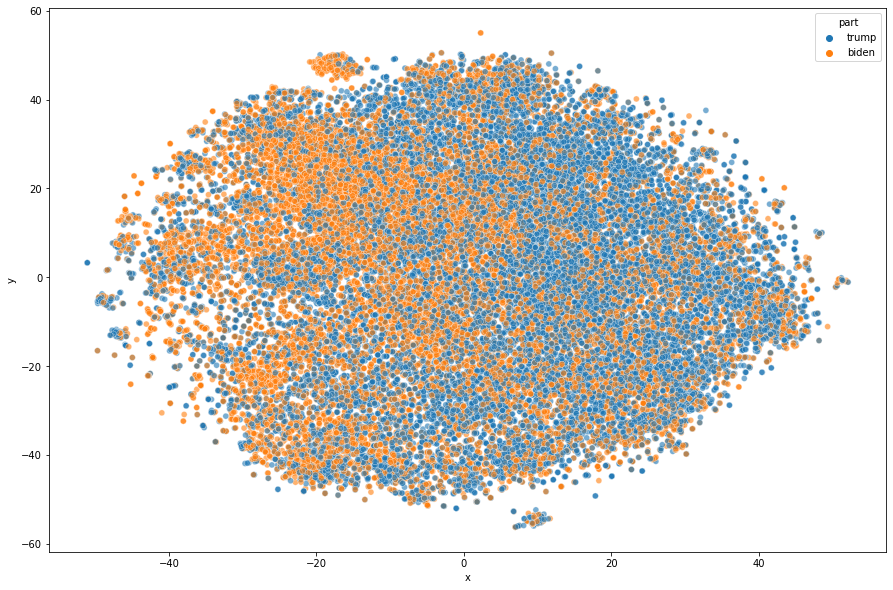

CPU times: user 1h 6min 32s, sys: 3.47 s, total: 1h 6min 35s
Wall time: 1h 2min 39s


In [ ]:
%%time
plot_2d_tsne_representation_of_sentence(comments_df, alpha=0.6, label='part')

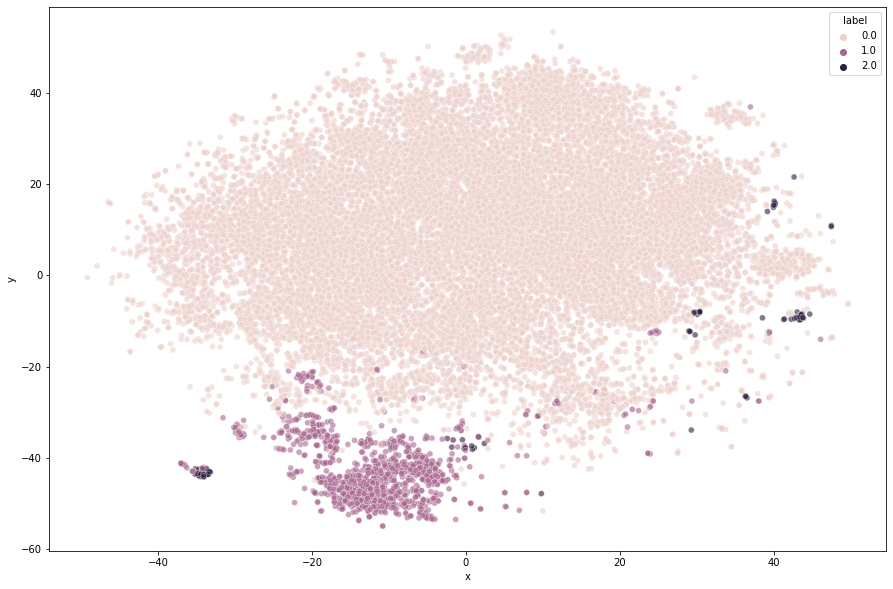

CPU times: user 1h 5min 45s, sys: 3.16 s, total: 1h 5min 48s
Wall time: 1h 2min 14s


In [ ]:
%%time
plot_2d_tsne_representation_of_sentence(comments_df, alpha=0.6)

# Кластеризация dbscan optics

In [ ]:
%%time
optics_model = OPTICS(min_samples=25, max_eps=0.6, metric='cosine')
optics_model.fit(list(comments_df['embedding']))
comments_df['label'] = optics_model.labels_

CPU times: user 1h 1min 44s, sys: 1h 59min 3s, total: 3h 48s
Wall time: 45min 32s


In [ ]:
comments_df['label'].value_counts()

0    20000
Name: label, dtype: int64

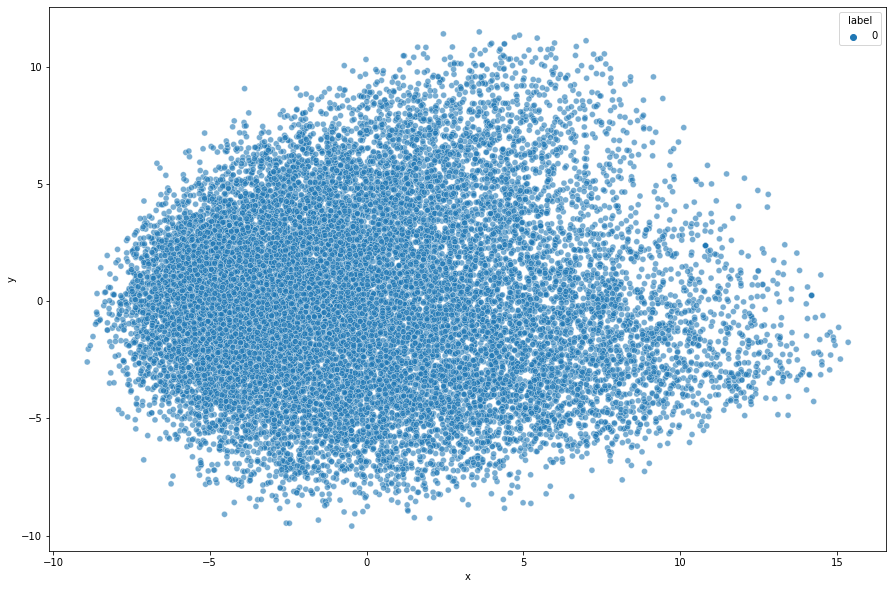

CPU times: user 8.81 s, sys: 2.96 s, total: 11.8 s
Wall time: 7.58 s


In [ ]:
%%time
plot_2d_pca_representation_of_sentence(comments_df, alpha=0.6)